In [2]:
# TODO:
# - Detect duplicates
# - Detect multiple tile sizes
# - Detect animated tile sizes

from typing import Optional
import cv2
import json
import numpy as np
import os
import re
import time


TILE_SIZE = 16
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg", ".bmp", ".gif")
ASSET_PACKS = ("modernexteriors-win",)
EXCLUDED_TAGS = (
    "modernexteriors",
    "modern",
    "sorter",
    "animated",
    "animation",
    "single",
    "tileset",
    "character",
    "gifs",
    "16x16",
    "32x32",
    "48x48",
    "and",
    "the",
    "win",
)


class Base:
    def __init__(self, path: str):
        self.path: str = path
        self.kind: str = self.__class__.__name__.lower()
        self.tags: tuple[str] = self.__parse_tags(path, self.kind)

    def to_json(self) -> dict[str, str]:
        return {"kind": self.kind, "path": self.path, "tags": self.tags}

    @staticmethod
    def __parse_tags(path: str, kind: str) -> tuple[str]:
        # strip extension
        string = os.path.splitext(path)[0].lower()
        string = re.sub(r"[^a-z0-9]+", " ", string).strip()
        unique = [kind + "s"]
        for word in string.split():
            if (
                len(word) > 2
                and not word.isdigit()
                and word not in unique
                and word not in EXCLUDED_TAGS
            ):
                unique.append(word)
        return tuple(reversed(unique))

    def __str__(self):
        return f"{self.__class__.__name__}({self.path})"

    def __hash__(self) -> int:
        return hash(self.path)

    def __eq__(self, other: object) -> bool:
        if not isinstance(other, Base):
            return NotImplemented
        return self.path == other.path


class Character(Base):
    pass


class Animation(Base):
    pass


class Tile(Base):
    def __init__(self, path: str):
        super().__init__(path)
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        self.cv2: cv2 = self.__convert_to_monochrome(image)
        self.shape: tuple[int, int] = image.shape[1], image.shape[0]

    def to_json(self) -> dict[str, str]:
        as_json = super().to_json()
        as_json["shape"] = self.shape
        return as_json

    @staticmethod
    def __convert_to_monochrome(image: cv2) -> cv2:
        return image[:, :, 0:3].sum(axis=2) * image[:, :, 3]


class Single(Tile):
    def __init__(self, path: str):
        super().__init__(path)
        self.tilesets: list[Tileset] = []
        self.checksum: float = self.__calculate_checksum(self.cv2)

    def to_json(self) -> dict[str, str]:
        as_json = super().to_json()
        as_json["tilesets"] = [tileset.path for tileset in self.tilesets]
        return as_json

    def add_tileset(self, tileset: "Tileset") -> None:
        self.tilesets.append(tileset)

    @staticmethod
    def __calculate_checksum(image: cv2) -> float:
        # pre-compute the sum of top-left tile
        # this is used later to speed up the search
        return image[:TILE_SIZE, :TILE_SIZE].sum()


class Tileset(Tile):
    def __init__(self, path: str):
        super().__init__(path)
        self.tiles: dict[Single, tuple[int, int]] = {}
        self.checksums: np.array = self.__calculate_checksums(self.cv2)

    def to_json(self) -> dict[str, str]:
        as_json = super().to_json()
        as_json["tiles"] = {
            single.path: position for single, position in self.tiles.items()
        }
        return as_json

    def search(self, single: Single) -> Optional[tuple[int, int]]:
        # check if the single image is in the tileset
        sh, sw = single.cv2.shape[:2]
        th, tw = self.cv2.shape[:2]
        for i in range(0, th - sh + 1, TILE_SIZE):
            for j in range(0, tw - sw + 1, TILE_SIZE):
                if single.checksum != self.checksums[i // TILE_SIZE, j // TILE_SIZE]:
                    continue
                tile = self.cv2[i : i + sh, j : j + sw]
                if (tile == single.cv2).all():
                    return j, i, j + sw, i + sh
        return None

    def add_tile(self, single: Single, position: tuple[int, int]) -> None:
        self.tiles[single] = position

    @staticmethod
    def __calculate_checksums(image: cv2) -> int:
        # pre-compute the sum of each tile
        # this is used later to speed up the search
        h = image.shape[0] // TILE_SIZE
        w = image.shape[1] // TILE_SIZE
        sums = np.zeros((h, w))
        for i in range(h):
            for j in range(w):
                tile = image[
                    i * TILE_SIZE : (i + 1) * TILE_SIZE,
                    j * TILE_SIZE : (j + 1) * TILE_SIZE,
                ]
                sums[i, j] = tile.sum()
        return sums


def load_image(path: str) -> Optional[Base]:
    lower = path.lower()
    ext = os.path.splitext(path)[1]
    if ext not in IMAGE_EXTENSIONS:
        return None
    if "32x32" in lower or "48x48" in lower:
        return None
    elif "animated" in lower or "animation" in lower:
        if ext != ".gif":
            return None
        return Animation(path)
    elif "character" in lower:
        return Character(path)
    elif "single" in lower:
        return Single(path)
    else:
        return Tileset(path)


if __name__ == "__main__":
    singles = []
    tilesets = []
    all_images = {}

    # iterate over all files in the asset pack
    for asset_pack in ASSET_PACKS:
        for root, dirs, files in os.walk(asset_pack):
            print(f"Loading {root}...")
            for file in files:
                path = os.path.join(root, file)
                image = load_image(path)
                if image is None:
                    continue
                all_images[path] = image
                if isinstance(image, Single):
                    singles.append(image)
                elif isinstance(image, Tileset):
                    tilesets.append(image)

    print(f"Loaded {len(singles)} singles and {len(tilesets)} tilesets.")

    # iterate over all singles and search for them in the tilesets
    n = len(singles)
    start = time.time()
    for i, single in enumerate(singles, start=1):
        # check if the single is in any of the tilesets
        for tileset in tilesets:
            result = tileset.search(single)
            if result:
                tileset.add_tile(single, result)
                single.add_tileset(tileset)

        if i % 20 == 0:
            left = time.gmtime((time.time() - start) / i * (n - i + 1))
            print(f"Processed {i}/{n}, {left.tm_min}m {left.tm_sec}s left...")

        #     json_data = {k: v.to_json() for k, v in all_images.items()}
        #     with open("dist/data.json", "w") as f:
        #         json.dump(json_data, f)

    json_data = {k: v.to_json() for k, v in all_images.items()}
    with open("dist/data.json", "w") as f:
        json.dump(json_data, f)

    print(f"Done in {time.time() - start:.2f}s.")


Loading modernexteriors-win...
Loaded 1 singles and 1 tilesets.
Done in 0.00s.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [11]:
singles[0].cv2.shape, tilesets[0].cv2.shape

((176, 144), (912, 512))

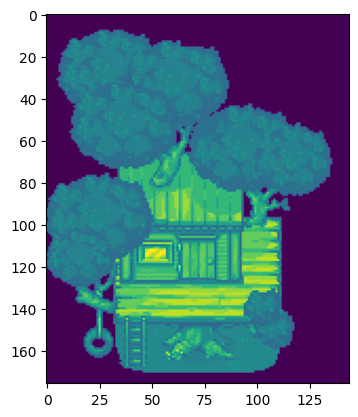

In [6]:
single = singles[0].cv2
plt.imshow(single)

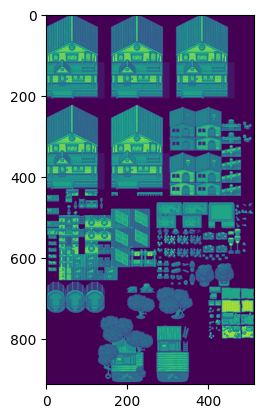

In [7]:
tileset = tilesets[0].cv2
plt.imshow(tileset)

((176, 144), (736, 912, 128, 272))

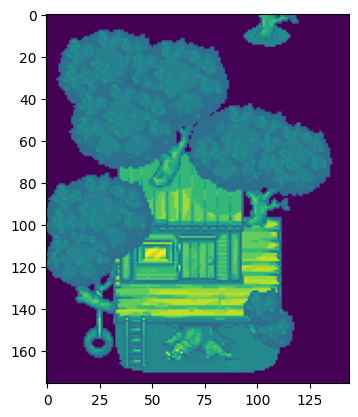

In [24]:
y, x = 46*16, 8*16
h, w = single.shape
partial = tileset[y:y+h,x:x+w]
plt.imshow(partial)
(h, w), (y, y+h, x, x+w)

True

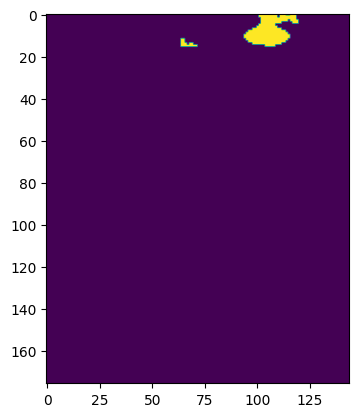

In [54]:
diff = single != partial
plt.imshow(diff)
diff.any()

In [53]:
np.count_nonzero(diff) / partial.size

0.010535037878787878

In [55]:
np.count_nonzero(diff)

267

In [56]:
diff.sum()

267

In [52]:
partial.size

25344